In [3]:
from src import host
from src import common
from src.setup import *

# Introduction

As an non-interactive usage of this notebook, one can use `sbatch src/run_gwas.sh` to send a job and get the results in a notebook or in HTML format. 

**TODO**: 

# README !

This notebook is special: it's designed differently from the others. To use this notebook effciently and interactively, first use `sbatch src/run_gwas.sh` to run a job that...

###### A word about `run_gwas()` function

Every output is stored. Warnings are displayed in `concatenated_warnings`, and the whole reports in `concatenated_logs` (both paths are defined in `setup.py`).

# Compute assciation tests



In [2]:
#host.run_gwas()

# Check the results

###### Report computational time


In [3]:
!cat $PATH_ASIANS_GWAS_TMP_LOGS_CONCAT | grep "Start time:" | head -1 
!cat $PATH_ASIANS_GWAS_TMP_LOGS_CONCAT | grep "End time:" | tail -1 

Start time: Tue Aug 20 18:20:28 2019
grep: erreur d'écriture
cat: erreur d'écriture: Relais brisé (pipe)
End time: Tue Aug 20 18:38:07 2019


This took about 18 min 30 s.

###### Look at warnings



In [4]:
# count warnings
print("Number of warnings: ", end='')
!grep $PATH_ASIANS_GWAS_TMP_LOGS_CONCAT -e Warning | wc -l

Number of warnings: 633


In [6]:
!head -3 $PATH_ASIANS_GWAS_TMP_WARNINGS


(PC_9_V) Warning: --glm remaining case count is less than 10x predictor count for
phenotype 'PC_9_V'.


We have 633/744 amino acids that do not respect the 1 to 10 rule of the thumb.

###### Skipped amino acids


In [6]:
!grep $PATH_ASIANS_GWAS_TMP_WARNINGS -e Skipping | wc -l

37


We have 37 amino acids that were skipped with the following warning:

    (S_19_P) Warning: Skipping --glm regression on phenotype <AA> since # samples <= #
    predictor columns.
    (Quasi-)separated covariate(s) were present.  Try removing inappropriate
    covariates, and/or using Firth logistic regression.

# Summarize & filter results

## Compute p-value summaries and filter with threshold

For each amino acid:

* We filter results with the threshold, add a column with the amino acid reference and concatenate the results
* We generate summary statistics for the p-values (SNPs + covariates) and include it as a column (the column name being the amino acid reference) in a table
* We generate summary statistics for the p-values of the SNPs (no covariates included)

**Warning: this takes a while (> 30 min).**

In [7]:
# 1. Get all files in the temporary results directory
from os import walk
f = []
for (dirpath, dirnames, filenames) in walk(PATH_ASIANS_GWAS_TMP):
    f = filenames    

In [8]:
threshold = 5e-8

In [9]:
# 2. For each plink report file, get p-values and summarize them
summaries = pd.DataFrame()
summaries_snps = pd.DataFrame()
concat = pd.DataFrame()
for i in f:
    if i[-9:] != '.logistic': continue 
    print('.', end='')
    df = pd.read_csv(PATH_ASIANS_GWAS_TMP+i, sep='\t')
    summary = df.P.describe()
    summary.name = i.split('.')[1]
    summary_snps = df[ df.TEST == 'ADD' ].P.describe() # select only p-values for SNPs
    summary_snps.name = i.split('.')[1]
    filtered = df[ df.P <= threshold ] 
    filtered['AA'] = [i.split('.')[1]] * filtered.shape[0]
    if summaries.empty: 
        summaries = pd.DataFrame(summary)
        summaries_snps = pd.DataFrame(summary_snps)
        concat = pd.DataFrame( filtered )
    else: 
        summaries.insert(loc=0, column=i.split('.')[1], value=summary)
        summaries_snps.insert(loc=0, column=i.split('.')[1], value=summary_snps)
        concat = concat.append(filtered, ignore_index=True)
print()

..

/home/mazeller/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [10]:
# 3. Save the results
common.write_binary(PATH_ASIANS_GWAS_TMP_SUMMARY, summaries)
common.write_binary(PATH_ASIANS_GWAS_FILTERED, concat)
common.write_binary(PATH_ASIANS_GWAS_TMP_SUMMARY_SNPS, summaries_snps)

write_binary(): successfully written in 'data/plink/gwas/pval_summary'
write_binary(): successfully written in 'data/plink/gwas/filtered_g2g'
write_binary(): successfully written in 'data/plink/gwas/pval_summary_snps'


## Statistics on SNP-p-value summaries

In [8]:
with open(PATH_ASIANS_GWAS_TMP_SUMMARY_SNPS, 'rb') as file:
    df = pickle.load(file)

In [33]:
print("DataFrame containing statistic summaries of p-values for every amino acid that was tested:")
df.loc[:, np.random.choice(df.columns.values, size=6)]

DataFrame containing statistic summaries of p-values for every amino acid that was tested:


,Pol_617_E,Pol_206_P,PC_108_P,Pol_624_I,S_114_N,S_230_P
count,154760.000000,163990.000000,34.000000,28274.000000,9932.000000,763.000000
mean,0.494626,0.495551,0.363614,0.454594,0.654745,0.991211
std,0.281275,0.290087,0.330374,0.268580,0.252537,0.022060
min,0.000098,0.000044,0.003333,0.000114,0.006030,0.890236
25%,0.252816,0.241494,0.067961,0.229965,0.493756,0.996659
50%,0.488282,0.493717,0.256824,0.427179,0.707108,0.998154
75%,0.733023,0.746613,0.649933,0.665216,0.860763,0.999240
max,0.999997,0.999999,0.965263,0.999884,0.999963,1.000000


Now we make summary statistics of the summary statistics... For each summary statistic of the table above, we compute the summary statistics among all amino acids (we compute statistics for each row of the table, those will be inserted as columns in the table below).

In [38]:
df_summary = pd.DataFrame(df.loc['mean'].describe())
rows = ['std', 'min', '25%', '50%', '75%', 'max']
for r in rows:
    df_summary[r] = df.loc[r].describe()
df_summary.drop('count', axis=0, inplace=True)
df_summary

,mean,std,min,25%,50%,75%,max
mean,0.523212,0.250829,1.003225e-01,0.317075,0.511991,0.724496,0.973434
std,0.183638,0.083681,2.748930e-01,0.243611,0.199840,0.164530,0.129062
min,0.025849,0.000000,1.947920e-13,0.013235,0.025849,0.025849,0.025849
25%,0.484316,0.269889,1.922910e-05,0.229926,0.474882,0.731825,0.999958
50%,0.492665,0.286613,8.511255e-05,0.242587,0.488228,0.741184,0.999992
75%,0.509177,0.289439,2.328043e-03,0.271306,0.506736,0.751404,0.999997
max,0.998267,0.386736,9.982670e-01,0.998267,0.999365,0.999704,1.000000


Explanation for the `mean` *column*: for each amino acids, we made a list of the p-values that were related to the tested SNPs (excluding covariates). This list thus has a length that is equal to the number of amino acids. Now we compute summary statistics for this list (each these statistics is a row in the table above), thus we summarize the mean p-value for all SNPs among every amino acid.

For instance, we observe that
* the most significant association ever observed in the analysis between a SNP and an amino acid (row `min`, column `min`) has a p-value of `1.947920e-13`
* the amount of significant associations is probably low: the average p-value among all the smallest observed p-values is `1.003225e-01` (row `mean`, column `min`).

In [69]:
df_plot = df.transpose().drop('count', axis=1)

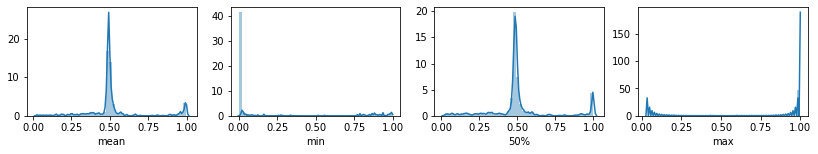

In [81]:
boxes = ['mean', 'min', '50%', 'max']
fig, ax = plt.subplots(1, len(boxes), figsize=(14,2))
for i, b in enumerate(boxes):
    sns.distplot(df_plot[b].dropna(), ax=ax[i])

# Analysis of filtered results

Here, we want to investigate the most significant associations in the results that were filtered by the threshold defined above.

###### Plan

* See which variables (and covariates) have the biggest number of associations
* Investigate the associations for the additive effects
* Investigate the associations by grouping by SNPs.

In [46]:
# Load the filtered results
# Pay attention to the RAM available, it's a big file (about 2Go)
with open(PATH_ASIANS_GWAS_FILTERED, 'rb') as file:
    df_results = pickle.load(file)

In [50]:
# See how it looks like
print("Shape of the DataFrame:", df_results.shape)
df_results.head(2)

Shape of the DataFrame: (20247946, 13)


,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,AA
0,1,14677,rs201327123,G,A,A,VPC1,397,0.586538,0.080103,-6.66038,2.731220e-11,S_179_T
1,1,14933,rs199856693,G,A,A,VPC1,433,0.629773,0.062398,-7.41044,1.258810e-13,S_179_T


In [53]:
aa_counts = df_results.AA.value_counts()
print("There are {} different amino acids that contain at least 1 significant association (variable or covariate)"
     .format(len(aa_counts)))

There are 223 amino acids that contain at least 1 significant association (variable or covariate)


## Rate of significant associations for each variable of the model

In [51]:
df_results.TEST.value_counts()

VPC1    10748966
VPC5     4038924
VPC6     2752348
VPC2     2529906
VPC3      161430
VPC4       15975
ADD          318
AGE           78
HPC3           1
Name: TEST, dtype: int64

We observed **318 significant associations** between a SNP and an amino acid at the $5*10^{-8}$ level (this is represented by the keyword `ADD`, for additive effects).

## Associations SNP<->AA

In [84]:
# Among the filtered results, keep only the tests done on the additive effects of SNPs
df_snps = df_results[ df_results.TEST == 'ADD' ]
df_snps.shape

(318, 13)

In [86]:
df_snps.AA.value_counts()

PC_160_A     213
PC_160_P      64
Pol_49_N      21
PC_142_D      14
Pol_584_T      2
S_45_F         1
S_51_P         1
Pol_215_Q      1
S_35_R         1
Name: AA, dtype: int64

In [87]:
df_snps.ID.value_counts()

rs2296651      3
rs151233761    2
rs41549018     2
rs376806238    2
rs73414461     2
              ..
rs1131279      1
rs2294415      1
rs11757135     1
rs2231095      1
rs61315420     1
Name: ID, Length: 252, dtype: int64